In [130]:
import os
import shutil
from random import shuffle
import yaml
import json

In [131]:
base_folder_function = lambda x: f".\\data\\segmentation\\{x}"
variants = ["train", "test", "valid"]
# New variants will only contain train and valid

train_test_split = 0.8

output_folder = "./output"

categories_to_keep = [1, 3, 10]


In [132]:
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

for variant in ["train", "valid"]:
    annotations_folder = os.path.join(output_folder, variant, 'labels')
    if not os.path.exists(annotations_folder):
        os.makedirs(annotations_folder)
        
    image_folder = os.path.join(output_folder, variant, 'images')
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)

In [133]:
def construct_annotation_line(image_width: int, image_height: int, annotation: dict):
    class_id = categories_to_keep.index(annotation["category_id"])

    # Extract COCO bounding box
    x_min, y_min, width, height = annotation["bbox"]

    # Convert to YOLO format
    x_center = (x_min + width / 2) / image_width
    y_center = (y_min + height / 2) / image_height
    norm_width = width / image_width
    norm_height = height / image_height

    return f"{class_id} {x_center} {y_center} {norm_width} {norm_height}"

In [134]:
# {"image": path/to/image, "annotations": str_including_newlines}
combination = []

for variant in variants:
    base_folder = base_folder_function(variant)
    annotations_file = os.path.join(base_folder, "_annotations.coco.json")
    
    with open(annotations_file, "r") as f:
        data = json.load(f)
        
    category_names = [x["name"] for x in data["categories"]] 
        
    for image in data["images"]:
        image["annotations"] = list(filter(lambda x: x["image_id"] == image["id"], data["annotations"]))

        # Image
        comb = {"image": str(os.path.join(base_folder, image["file_name"]))}
        
        # Output the annotation
        lines = [construct_annotation_line(image["width"], image["height"], x) for x in image["annotations"] if x["category_id"] in categories_to_keep]
        comb["annotations"] = "\n".join(lines)
        
        combination.append(comb)

In [135]:

train_set_size = int(round(len(combination) * train_test_split, 0))

shuffle(combination)
train_set = combination[:train_set_size]
test_set = combination[train_set_size:]

train_output_folder = os.path.join(output_folder, "train")
for comb in train_set:
    base_file_name = comb["image"].rsplit("\\", 1)[1].rsplit(".", 1)[0]
    shutil.copyfile(comb["image"], str(os.path.join(train_output_folder, "images", base_file_name + ".jpg")))
    
    file_name = str(os.path.join(train_output_folder, "labels", base_file_name + ".txt"))
    with open(file_name, "w") as f:
        f.write(comb["annotations"])

test_output_folder = os.path.join(output_folder, "valid")
for comb in test_set:
    base_file_name = comb["image"].rsplit("\\", 1)[1].rsplit(".", 1)[0]
    shutil.copyfile(comb["image"], str(os.path.join(test_output_folder, "images", base_file_name + ".jpg")))
    
    file_name = str(os.path.join(test_output_folder, "labels", base_file_name + ".txt"))
    with open(file_name, "w") as f:
        f.write(comb["annotations"])

In [136]:
category_names = []
with open(os.path.join(base_folder_function(variants[0]), "_annotations.coco.json"), "r") as f:
    data = json.load(f)
    for category in data["categories"]:
        if category["id"] in categories_to_keep:
            category_names.append(category["name"])            
    
content = {
    "nc": len(categories_to_keep),
    "train": "train/images",
    "val": "valid/images",
    "names": category_names
}

with open(os.path.join(output_folder, "data.yaml"), "w") as f:
    yaml.dump(content, f)

# Testing

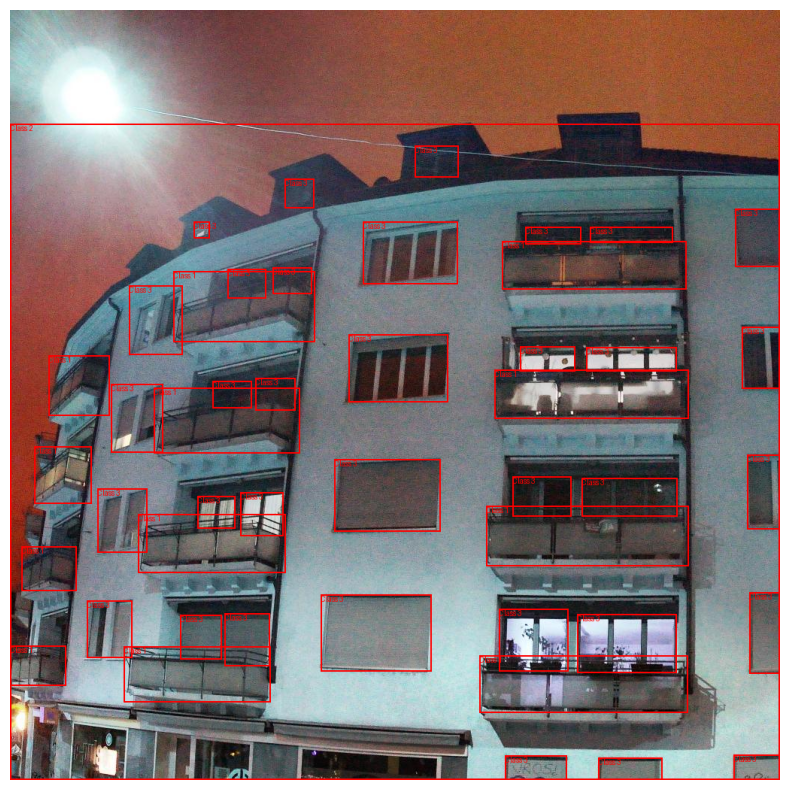

In [137]:
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def display_image_with_boxes(image_path, annotation_path):
    """
    Displays an image with bounding boxes drawn on top.

    Args:
        image_path (str): Path to the image file.
        annotation_path (str): Path to the annotation file in YOLO format.
    """
    # Load image
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    # Load YOLO annotations
    with open(annotation_path, "r") as f:
        annotations = f.readlines()

    # Get image dimensions
    img_width, img_height = image.size

    # Draw each bounding box
    for annotation in annotations:
        data = annotation.strip().split()
        if len(data) == 0:
            continue
        class_id = int(data[0])
        x_center, y_center, width, height = map(float, data[1:])

        # Convert YOLO format (normalized) to pixel values
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        x_max = (x_center + width / 2) * img_width
        y_max = (y_center + height / 2) * img_height

        # Draw rectangle and label
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
        draw.text((x_min, y_min), f"Class {class_id}", fill="red")

    # Display image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Example usage
image_path = "output/valid/images/20230329_202916_077_R_scaled_0_png_jpg.rf.d38f8978ea976620e37655d436d94165.jpg"          # Path to the image
annotation_path = "output/valid/labels/20230329_202916_077_R_scaled_0_png_jpg.rf.d38f8978ea976620e37655d436d94165.txt"  # Path to the corresponding YOLO annotation file

display_image_with_boxes(image_path, annotation_path)
